In [64]:
# Import libraries
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")
plt.style.use('ggplot')

In [65]:
# Read in the trip summary data
file_path = '../data/trip_summary_201808_201903.csv'
trips = pd.read_csv(file_path)
trips = trips.dropna(how="any") # drop NaNs

trips['start_station_id'].nunique()

161

In [66]:
# Create a month column
trips['month'] = trips.start_date.str[5:7]
trips['start_station_id'].nunique()

161

### Create station pair identifiers and sort the data

In [67]:
# Function: sorts the pair array and concatenates them to create a unique ID
def sort_concat(arr):
    arr_sorted = np.sort(arr)
    pair_id = str(arr_sorted[0]) + '_' + str(arr_sorted[1])
    
    return pair_id

### Generate an affinity matrix from the data

In [101]:
from sklearn.preprocessing import MinMaxScaler

# Function to filter to stations that have both incoming / outgoing trips
# This is to avoid start_station / end_station mismatches when generating affinity matrix
# def filter_stations(trips_data):
#     start_stns = trips_data['start_station_id'].unique()
#     end_stns = trips_data['end_station_id'].unique()

#     intersecting_stns = list(set(start_stns).intersection(end_stns))             
#     filtered_trips = trips_data[trips_data['start_station_id'].isin(intersecting_stns)
#                            & trips_data['end_station_id'].isin(intersecting_stns)]
    
#     return filtered_trips

# Function to generate affinity matrix
def generate_aff_mat(trips):
    pair_id = trips[['start_station_id', 'end_station_id']].values
    pair_id_sorted = list(map(sort_concat, pair_id))
    trips['station_pair_id'] = pair_id_sorted

    # Create a new dataframe that sums the roundtrips between two stations into one row of data
    # We will be able to create a matrix on how each station interactions with other stations
    pair_trips = trips.groupby('station_pair_id', as_index=False)['trip_count','sum_duration_min'].sum()

    pair_trips['station_i'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[0]
    pair_trips['station_j'] = pair_trips['station_pair_id'].str.split("_", n = 1, expand = True)[1]
    intercluster_volume = pair_trips
    pair_trips['trip_count_inv'] = 1 / pair_trips['trip_count']

    # Normalize trip_count, trip_count_inv and sum_duration_min so we can compare accross months and/or different time periods
    scaler = MinMaxScaler(feature_range=(0, 1))
    array = pair_trips[['trip_count','sum_duration_min','trip_count_inv']].values
    array_scaled = scaler.fit_transform(array)
    pair_trips[['trip_count','sum_duration_min','trip_count_inv']] = array_scaled

    pair_trips['station_i'] = pd.to_numeric(pair_trips['station_i']).astype(np.int64)
    pair_trips['station_j'] = pd.to_numeric(pair_trips['station_j']).astype(np.int64)

    # Sort the dataframe by the starting station, so we can link up the clusters to the correct row of data later on
    stations_sorted = pair_trips.sort_values(['station_i'])['station_i'].unique()
    pair_trips = pair_trips.sort_values(['station_i'])

    # Generate affinity matrix from pair_trips
    upp_mat = pair_trips.set_index(['station_i','station_j'])['trip_count_inv'].unstack().values
#     print(upp_mat.shape)
    aff_mat = np.triu(upp_mat) + np.triu(upp_mat, 1).T
    aff_mat[np.isnan(aff_mat)] = 0

    # Create similarity matrix to feed into Spectral Clustering algorithm
    beta = 1
    sim_mat = np.exp(-beta * aff_mat / aff_mat.std(ddof=0))

    return sim_mat

# Test function
filtered_trips = trips[trips['month'] == '10']
# filtered_trips = filter_stations(filtered_trips)

generate_aff_mat(filtered_trips)

array([[0.97073073, 0.88457608, 0.97394938, ..., 0.90274308, 1.        ,
        0.4422492 ],
       [0.88457608, 0.84443835, 0.82747593, ..., 0.62828416, 1.        ,
        1.        ],
       [0.97394938, 0.82747593, 0.94827954, ..., 0.87015222, 1.        ,
        0.62828416],
       ...,
       [0.90274308, 0.62828416, 0.87015222, ..., 0.95750925, 1.        ,
        0.0378655 ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.76361113,
        1.        ],
       [0.4422492 , 1.        , 0.62828416, ..., 0.0378655 , 1.        ,
        0.79399082]])

### Perform Spectral Clustering on each month of trips data

In [102]:
from sklearn.cluster import SpectralClustering

def compute_cluster_metrics(trips_data, num_clusters, intercluster_volume):
    sim_mat = generate_aff_mat(trips_data) # Generate aff matrix
    
    sc = SpectralClustering(i, affinity='precomputed', n_init=100, assign_labels='discretize')
    clusters = sc.fit_predict(sim_mat)

    # select start station and trip count to new dataframe
    intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

    #define a mapping dictionary
    cluster_dict = dict(zip(stations_sorted, clusters))

    # map the clusters to the starting stations
    intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
    intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)

    # ----------------------------------------------------------------------------------------------------------------------------------------
    # concat start and end cluster
    intercluster_volume['start_end_cluster'] = intercluster_volume.cluster_i.map(str) + "|" + intercluster_volume.cluster_j.map(str)

    # Group by start and end cluster summing the trip count and duration
    intercluster_volume_grp = intercluster_volume.groupby('start_end_cluster', as_index=False)['trip_count','sum_duration_min'].sum()

    # Figure out which are intra vs inter
    s = intercluster_volume_grp['start_end_cluster'].apply(lambda x: x.split('|'))
    intercluster_volume_grp['start'] = s.apply(lambda x: x[0])
    intercluster_volume_grp['end'] = s.apply(lambda x: x[1])
    
    intercluster_volume_grp.loc[intercluster_volume_grp['start'] != intercluster_volume_grp['end'], 'intercluster_trip'] = 1
    intercluster_volume_grp.loc[intercluster_volume_grp['start'] == intercluster_volume_grp['end'], 'intercluster_trip'] = 0
    
    intercluster_volume_grp.loc[intercluster_volume_grp['start'] == intercluster_volume_grp['end'], 'intracluster_trip'] = 1
    intercluster_volume_grp.loc[intercluster_volume_grp['start'] != intercluster_volume_grp['end'], 'intracluster_trip'] = 0

    # get inter trip volume and duration time
    intercluster_volume_grp['intercluster_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['trip_count']
    intercluster_volume_grp['intercluster_time_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['sum_duration_min']

    # get intra trip volume and duration time
    intercluster_volume_grp['intracluster_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['trip_count']
    intercluster_volume_grp['intracluster_time_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['sum_duration_min']

    # add column for cluster size that will be used to group on
    intercluster_volume_grp['cluster_size'] = i

    # group on cluster size to sum all of the inter and intra stats
    intercluster_volume_grp_final = intercluster_volume_grp.groupby('cluster_size', as_index=False)['intercluster_volume','intercluster_time_volume', 'intracluster_volume', 'intracluster_time_volume'].sum()

    # calculate the intra : inter ration for volume and time
    intercluster_volume_grp_final['intra_inter_vol_ratio'] = intercluster_volume_grp_final['intracluster_volume'] / intercluster_volume_grp_final['intercluster_volume']
    intercluster_volume_grp_final['intra_inter_time_ratio'] = intercluster_volume_grp_final['intracluster_time_volume'] / intercluster_volume_grp_final['intercluster_time_volume']

    return clusters, intercluster_volume_grp_final

# Declare parameters
months_to_run = ['08', '09', '10', '01', '02', '03'] # '11', '12' has issues generating upper matrix
month = []
cluster_list = []
inter_vol_list = []
inter_time_list = []
intra_vol_list = []
intra_time_list = []
intra_inter_vol_list = []
intra_inter_time_list = []

print("clusters","  ", "inter_vol", " ", "inter_time",
      " ", "intra_vol", " ", "intra_time", 
      " ","intra_inter_vol",  " ", "intra_inter_time")

# Loop through each month and cluster count combinations and generate metrics
for mth in months_to_run:
    i = 2
    
    filtered_trips = trips.loc[trips['month'] == mth]
#     filtered_trips = filter_stations(filtered_trips)
    
    while i <= 15:
        clusters, computed_metrics = compute_cluster_metrics(filtered_trips, i, intercluster_volume)
        
        # ----------------------------------------------------------------------------------------------------------------------------------------
        print(i,
              "      ", round(computed_metrics['intercluster_volume'][0],4),
              "      ", round(computed_metrics['intercluster_time_volume'][0],4),
              "      ", round(computed_metrics['intracluster_volume'][0],4),
              "      ", round(computed_metrics['intracluster_time_volume'][0],4),
              "      ", round(computed_metrics['intra_inter_vol_ratio'][0],4),
              "      ", round(computed_metrics['intra_inter_time_ratio'][0],4))
    
        # Build list for month
        month.append(mth)
    
        # Build list to enable plotting
        cluster_list.append(i)
    
        # Build list Inter volume
        inter_vol_list.append(computed_metrics['intercluster_volume'][0])
        inter_time_list.append(computed_metrics['intercluster_time_volume'][0])
    
        # Build list Intra volume
        intra_vol_list.append(computed_metrics['intracluster_volume'][0])
        intra_time_list.append(computed_metrics['intracluster_time_volume'][0])
    
        # Build list for Intra:inter ratio
        intra_inter_vol_list.append(computed_metrics['intra_inter_vol_ratio'][0])
        intra_inter_time_list.append(computed_metrics['intra_inter_time_ratio'][0])
        
        i += 1

clusters    inter_vol   inter_time   intra_vol   intra_time   intra_inter_vol   intra_inter_time
2        76.7964        63.2915        88.728        69.7345        1.1554        1.1018
3        95.7268        78.6984        69.7976        54.3276        0.7291        0.6903
4        109.1566        88.2029        56.3678        44.8231        0.5164        0.5082
5        112.8654        90.9419        52.659        42.0841        0.4666        0.4628
6        120.5892        95.9794        44.9353        37.0466        0.3726        0.386
7        127.0753        101.4867        38.4491        31.5393        0.3026        0.3108
8        131.8892        104.599        33.6352        28.427        0.255        0.2718
9        136.0316        107.2836        29.4928        25.7424        0.2168        0.2399
10        132.9383        105.2837        32.5861        27.7424        0.2451        0.2635
11        139.1749        109.1999        26.3495        23.8261        0.1893        0

### Don't run this code unless you repopulate the lists

In [103]:
spec_clust_final = pd.DataFrame({'a':range(len(month))})

spec_clust_final['month'] = pd.Series(month, index = spec_clust_final.index[:len(month)])
spec_clust_final['cluster'] = pd.Series(cluster_list, index = spec_clust_final.index[:len(cluster_list)])
spec_clust_final['inter_vol'] = pd.Series(inter_vol_list, index = spec_clust_final.index[:len(inter_vol_list)])
spec_clust_final['inter_time'] = pd.Series(inter_time_list, index = spec_clust_final.index[:len(inter_time_list)])
spec_clust_final['intra_vol'] = pd.Series(intra_vol_list, index = spec_clust_final.index[:len(intra_vol_list)])
spec_clust_final['intra_time'] = pd.Series(intra_time_list, index = spec_clust_final.index[:len(intra_time_list)])
spec_clust_final['intra_inter_vol'] = pd.Series(intra_inter_vol_list, index = spec_clust_final.index[:len(intra_inter_vol_list)])
spec_clust_final['intra_inter_time'] = pd.Series(intra_inter_time_list, index = spec_clust_final.index[:len(intra_inter_time_list)])

spec_clust_final

,a,month,cluster,inter_vol,inter_time,intra_vol,intra_time,intra_inter_vol,intra_inter_time
0,0,08,2,76.796404,63.291536,88.728024,69.734482,1.155367,1.101798
1,1,08,3,95.726843,78.698415,69.797584,54.327603,0.729133,0.690327
2,2,08,4,109.156647,88.202894,56.367781,44.823124,0.516393,0.508182
3,3,08,5,112.865420,90.941880,52.659008,42.084138,0.466565,0.462759
4,4,08,6,120.589175,95.979411,44.935252,37.046607,0.372631,0.385985
5,5,08,7,127.075282,101.486740,38.449146,31.539278,0.302570,0.310772
6,6,08,8,131.889212,104.598985,33.635216,28.427033,0.255026,0.271772
7,7,08,9,136.031602,107.283598,29.492826,25.742420,0.216809,0.239947
8,8,08,10,132.938340,105.283654,32.586088,27.742364,0.245122,0.263501
9,9,08,11,139.174900,109.199911,26.349528,23.826107,0.189327,0.218188


In [112]:
# Export to csv
spec_clust_final.to_csv("inter and intra cluster ratio results.csv", index=None)

In [113]:
spec_clust_final.tail()

,a,month,cluster,inter_vol,inter_time,intra_vol,intra_time,intra_inter_vol,intra_inter_time
79,79,03,11,127.794588,102.567527,37.729840,30.458491,0.295238,0.296960
80,80,03,12,103.859154,85.717351,61.665274,47.308667,0.593739,0.551915
81,81,03,13,125.118325,100.048972,40.406102,32.977046,0.322943,0.329609
82,82,03,14,126.850981,101.188670,38.673447,31.837348,0.304873,0.314634
83,83,03,15,134.653378,105.972770,30.871050,27.053248,0.229263,0.255285


### Cluster Visualization and Analysis

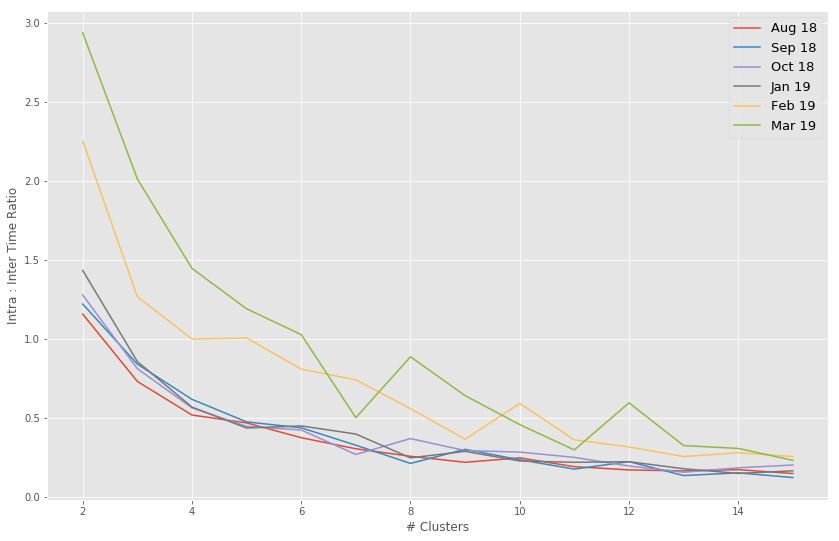

In [105]:
from matplotlib.pyplot import figure

figure(figsize=(14, 9))

clusters = spec_clust_final.loc[spec_clust_final['month'] == "01"]['cluster']

intra_inter_vol_plot_08 = spec_clust_final.loc[spec_clust_final['month'] == "08"]['intra_inter_vol']
intra_inter_vol_plot_09 = spec_clust_final.loc[spec_clust_final['month'] == "09"]['intra_inter_vol']
intra_inter_vol_plot_10 = spec_clust_final.loc[spec_clust_final['month'] == "10"]['intra_inter_vol']
# intra_inter_vol_plot_11 = spec_clust_final.loc[spec_clust_final['month'] == "11"]['intra_inter_vol']
# intra_inter_vol_plot_12 = spec_clust_final.loc[spec_clust_final['month'] == "12"]['intra_inter_vol']
intra_inter_vol_plot_01 = spec_clust_final.loc[spec_clust_final['month'] == "01"]['intra_inter_vol']
intra_inter_vol_plot_02 = spec_clust_final.loc[spec_clust_final['month'] == "02"]['intra_inter_vol']
intra_inter_vol_plot_03 = spec_clust_final.loc[spec_clust_final['month'] == "03"]['intra_inter_vol']

# Plot
plt.plot(clusters, intra_inter_vol_plot_08, label='Aug 18')
plt.plot(clusters, intra_inter_vol_plot_09, label='Sep 18')
plt.plot(clusters, intra_inter_vol_plot_10, label='Oct 18')
# plt.plot(clusters, intra_inter_vol_plot_11, label='Nov 18')
# plt.plot(clusters, intra_inter_vol_plot_12, label='Dec 18')
plt.plot(clusters, intra_inter_vol_plot_01, label='Jan 19')
plt.plot(clusters, intra_inter_vol_plot_02, label='Feb 19')
plt.plot(clusters, intra_inter_vol_plot_03, label='Mar 19')

plt.xlabel('# Clusters')
plt.ylabel('Intra : Inter Time Ratio')
plt.legend(loc=1, prop={'size': 13})


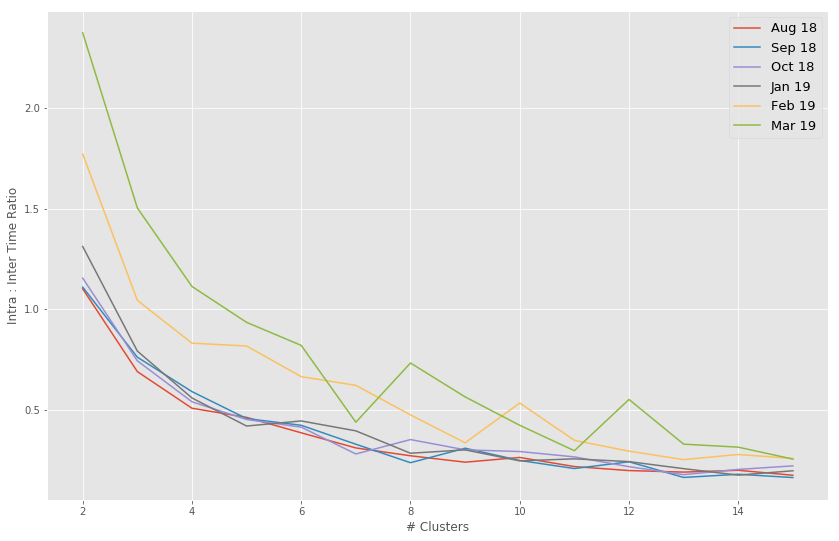

In [106]:
from matplotlib.pyplot import figure

figure(figsize=(14, 9))

clusters = spec_clust_final.loc[spec_clust_final['month'] == "01"]['cluster']

intra_inter_time_plot_08 = spec_clust_final.loc[spec_clust_final['month'] == "08"]['intra_inter_time']
intra_inter_time_plot_09 = spec_clust_final.loc[spec_clust_final['month'] == "09"]['intra_inter_time']
intra_inter_time_plot_10 = spec_clust_final.loc[spec_clust_final['month'] == "10"]['intra_inter_time']
# intra_inter_time_plot_11 = spec_clust_final.loc[spec_clust_final['month'] == "11"]['intra_inter_time']
# intra_inter_time_plot_12 = spec_clust_final.loc[spec_clust_final['month'] == "12"]['intra_inter_time']
intra_inter_time_plot_01 = spec_clust_final.loc[spec_clust_final['month'] == "01"]['intra_inter_time']
intra_inter_time_plot_02 = spec_clust_final.loc[spec_clust_final['month'] == "02"]['intra_inter_time']
intra_inter_time_plot_03 = spec_clust_final.loc[spec_clust_final['month'] == "03"]['intra_inter_time']

# Plot
plt.plot(clusters, intra_inter_time_plot_08, label='Aug 18')
plt.plot(clusters, intra_inter_time_plot_09, label='Sep 18')
plt.plot(clusters, intra_inter_time_plot_10, label='Oct 18')
# plt.plot(clusters, intra_inter_time_plot_11, label='Nov 18')
# plt.plot(clusters, intra_inter_time_plot_12, label='Dec 18')
plt.plot(clusters, intra_inter_time_plot_01, label='Jan 19')
plt.plot(clusters, intra_inter_time_plot_02, label='Feb 19')
plt.plot(clusters, intra_inter_time_plot_03, label='Mar 19')

plt.xlabel('# Clusters')
plt.ylabel('Intra : Inter Time Ratio')
plt.legend(loc=1, prop={'size': 13})


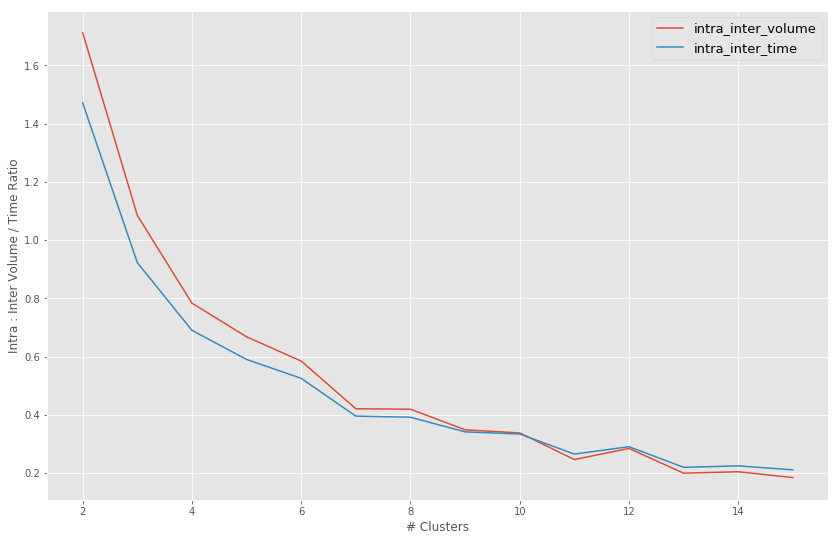

In [111]:
figure(figsize=(14, 9))

# Average intra_inter_vol per cluster across the months
spec_clust_volume_avg = spec_clust_final.groupby(['cluster'])['intra_inter_vol'].mean().reset_index()

# Average intra_inter_time per cluster across the months
spec_clust_time_avg = spec_clust_final.groupby(['cluster'])['intra_inter_time'].mean().reset_index()

# Plot the averaged results
plt.plot(spec_clust_volume_avg['cluster'], spec_clust_volume_avg['intra_inter_vol'], label='intra_inter_volume')
plt.plot(spec_clust_volume_avg['cluster'], spec_clust_time_avg['intra_inter_time'], label='intra_inter_time')

plt.xlabel('# Clusters')
plt.ylabel('Intra : Inter Volume / Time Ratio')
plt.legend(loc=1, prop={'size': 13})


In [ ]:
# Deprecated
plt.plot(cluster_list,avg_inter_time_list)

plt.xlabel('Number of Clusters')
plt.ylabel('Average Intercluster Time')
plt.title('Selection Criteria')
plt.show()


### Generate a Dataframe that has the pertinent information for Data Visualization

In [115]:
# Set params
mth = '03' # month to run clustering for
num_clusters = 9 # cluster

# Compute clusters
filtered_trips = trips.loc[trips['month'] == mth]
clusters, computed_metrics = compute_cluster_metrics(trips, num_clusters, intercluster_volume)

# Create dataframe to export
station_clustered = list(zip(stations_sorted, clusters))
df_station_clustered = pd.DataFrame(station_clustered)
df_station_clustered.rename(columns={0:'station_id',
                                    1: 'cluster'},inplace=True)

start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates().rename(columns = {'start_station_id':'station_id', \
                                                 'start_station_name':'station_name', \
                                                 'start_station_latitude':'station_latitude', 
                                                 'start_station_longitude': 'station_longitude'})

end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']].drop_duplicates().rename(columns = {'end_station_id':'station_id', \
                                             'end_station_name':'station_name', \
                                             'end_station_latitude':'station_latitude', \
                                             'end_station_longitude': 'station_longitude'})

df_loc = pd.concat([start, end]).drop_duplicates()
df_all = df_loc.merge(df_station_clustered, on=["station_id"], how="right")
df_all.to_csv("clusters_spectral_clustering.csv", index=None)
df_all.head()

,station_id,station_name,station_latitude,station_longitude,cluster
0,100,Bryant St at 15th St,37.767100,-122.410662,11
1,110,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,11
2,16,Steuart St at Market St,37.794130,-122.394430,0
3,343,Bryant St at 2nd St,37.783172,-122.393572,13
4,36,Folsom St at 3rd St,37.783830,-122.398870,7


### Archived Code: Generating the Intra : Inter Ratio

In [ ]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(3, affinity='precomputed', n_init=100, assign_labels='discretize')
clusters = sc.fit_predict(sim_mat)

# select start station and trip count to new dataframe
intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

#define a mapping dictionary
cluster_dict = dict(zip(stations_sorted, clusters))

# map the clusters to the starting stations
intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)

# concat start and end cluster
intercluster_volume['start_end_cluster'] = intercluster_volume.cluster_i.map(str) + "|" + intercluster_volume.cluster_j.map(str)

# Group by start and end cluster summing the trip count and duration
intercluster_volume_grp = intercluster_volume.groupby('start_end_cluster', as_index=False)['trip_count','sum_duration_min'].sum()

# Figure out which are intra vs inter
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 1
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intercluster_trip'] = 0

intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] == intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 1
intercluster_volume_grp.loc[intercluster_volume_grp.start_end_cluster.str[0] != intercluster_volume_grp.start_end_cluster.str[2], 'intracluster_trip'] = 0

# get inter trip volume and duration time
intercluster_volume_grp['intercluster_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['trip_count']
intercluster_volume_grp['intercluster_time_volume'] = intercluster_volume_grp['intercluster_trip']*intercluster_volume_grp['sum_duration_min']

# get intra trip volume and duration time
intercluster_volume_grp['intracluster_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['trip_count']
intercluster_volume_grp['intracluster_time_volume'] = intercluster_volume_grp['intracluster_trip']*intercluster_volume_grp['sum_duration_min']

# make this i in the loop
intercluster_volume_grp['cluster_size'] = 3

intercluster_volume_grp_final = intercluster_volume_grp.groupby('cluster_size', as_index=False)['intercluster_volume','intercluster_time_volume', 'intracluster_volume', 'intracluster_time_volume'].sum()

intercluster_volume_grp_final['intra_inter_vol_ratio'] = intercluster_volume_grp_final['intracluster_volume'] / intercluster_volume_grp_final['intercluster_volume']
intercluster_volume_grp_final['intra_inter_time_ratio'] = intercluster_volume_grp_final['intracluster_time_volume'] / intercluster_volume_grp_final['intercluster_time_volume']

# print(intercluster_volume_grp_final['intercluster_volume'][0])

intercluster_volume_grp_final.head(15)


### Archived Code: Single run of volume and time volume aggregation

In [ ]:
# map clusters to roundtrip volume and rountrip volume time data

# select start station and trip count to new dataframe
intercluster_volume = intercluster_volume[['station_i','station_j', 'trip_count','sum_duration_min']]

#define a mapping dictionary
cluster_dict = dict(zip(stations_sorted, clusters))

# map the clusters to the starting stations
intercluster_volume['cluster_i'] = intercluster_volume['station_i'].map(cluster_dict)
intercluster_volume['cluster_j'] = intercluster_volume['station_j'].map(cluster_dict)


intercluster_volume.loc[intercluster_volume.cluster_i == intercluster_volume.cluster_j, 'intercluster_trip'] = 0 
intercluster_volume.loc[intercluster_volume.cluster_i != intercluster_volume.cluster_j, 'intercluster_trip'] = 1 

intercluster_volume['intercluster_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['trip_count']
intercluster_volume['intercluster_time_volume'] = intercluster_volume['intercluster_trip']*intercluster_volume['sum_duration_min']

intercluster_volume.head()

### Archived Code: One-time Spectral Clustering Run

In [ ]:
# # One time Spectral clustering on the affinity matrix
# from sklearn.cluster import SpectralClustering

# sc = SpectralClustering(10, affinity='precomputed', n_init=100, assign_labels='discretize')
# clusters = sc.fit_predict(sim_mat)
# #print(len(clusters))